In [704]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
import json
from tqdm.notebook import tqdm
from scipy.stats import skew
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

In [705]:
with open("feature_dict.json", "r") as json_file:
    feature_dict = json.load(json_file)

In [706]:
df = pd.read_csv('train_prepared_for_cv.csv')

In [707]:
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object

In [708]:
sum(df.isna().sum())

357

In [709]:
X = df.drop(columns=['Id', 'SalePrice'])
y = df['SalePrice']

In [710]:
numeric_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
numeric_cols.remove("MSSubClass")
categorical_cols = [col for col in X.columns if col not in numeric_cols]
ordinal_encode_cols = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC", "Street", "Alley", "PavedDrive"]
label_encode_cols = [col for col in categorical_cols if col not in ordinal_encode_cols]
ohe_encode_cols = label_encode_cols

In [711]:
print(numeric_cols)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [712]:
print(categorical_cols)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [713]:
print(ordinal_encode_cols)

['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Street', 'Alley', 'PavedDrive']


In [714]:
print(label_encode_cols)

['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [715]:
print(len(categorical_cols))
print(len(ordinal_encode_cols), len(label_encode_cols), len(ohe_encode_cols))
print(len(ordinal_encode_cols) + len(label_encode_cols))
print(len(numeric_cols))
print(len(numeric_cols) + len(categorical_cols))

43
14 29 29
43
35
78


In [716]:
ordinal_mappings = {}

for col in ordinal_encode_cols:
    if col in X.columns and col in feature_dict:
        all_values = list(feature_dict[col]["values"].keys())  # Extract and preserve the order of values from the dict
        mapping = {category: rank for rank, category in enumerate(reversed(all_values), start=1)}  # Encode in the dict order
        mapping["No_item"] = -1
        if "NA" in mapping.keys():
            del mapping["NA"]
        ordinal_mappings[col] = mapping
        
def safe_map(value, mapping):
    if value not in mapping:
        raise ValueError(f"Value '{value}' not found in the mapping!")
    return mapping[value]

def ordinal_encode_column(X, mappings):
    encoded = X.copy()
    for col in X.columns:
        if col in mappings:
            encoded[col] = X.apply(lambda x: safe_map(x, mappings[col]))
    return encoded

print(ordinal_mappings)

{'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'BsmtQual': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'BsmtCond': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'BsmtExposure': {'No': 2, 'Mn': 3, 'Av': 4, 'Gd': 5, 'No_item': -1}, 'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'FireplaceQu': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'GarageQual': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'GarageCond': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'PoolQC': {'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'Street': {'Grvl': 1, 'Pave': 2, 'No_item': -1}, 'Alley': {'Grvl': 2, 'Pave': 3, 'No_item': -1}, 'PavedDrive': {'N': 1, 'P': 2, 'Y': 3, 'No_item': -1}}


In [717]:
label_mappings = {}

for col in label_encode_cols:
    if col in X.columns and col in feature_dict:
        all_values = list(feature_dict[col]["values"].keys())  # Extract and preserve the order of values from the dict
        mapping = {category: rank for rank, category in enumerate(reversed(all_values), start=1)}  # Encode in the dict order
        mapping["No_item"] = -1
        if "NA" in mapping.keys():
            del mapping["NA"]
        label_mappings[col] = mapping
        
def safe_map(value, mapping):
    if value not in mapping:
        raise ValueError(f"Value '{value}' not found in the mapping!")
    return mapping[value]

def label_encode_column(X, mappings):
    encoded = X.copy()
    for col in X.columns:
        if col in mappings:
            encoded[col] = df[col].apply(lambda x: safe_map(x, mappings[col]))
    return encoded

print(label_mappings)

{'MSSubClass': {'190': 1, '180': 2, '160': 3, '150': 4, '120': 5, '90': 6, '85': 7, '80': 8, '75': 9, '70': 10, '60': 11, '50': 12, '45': 13, '40': 14, '30': 15, '20': 16, 'No_item': -1}, 'MSZoning': {'RM': 1, 'RP': 2, 'RL': 3, 'RH': 4, 'I': 5, 'FV': 6, 'C': 7, 'A': 8, 'No_item': -1}, 'LotShape': {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4, 'No_item': -1}, 'LandContour': {'Low': 1, 'HLS': 2, 'Bnk': 3, 'Lvl': 4, 'No_item': -1}, 'Utilities': {'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4, 'No_item': -1}, 'LotConfig': {'FR3': 1, 'FR2': 2, 'CulDSac': 3, 'Corner': 4, 'Inside': 5, 'No_item': -1}, 'LandSlope': {'Sev': 1, 'Mod': 2, 'Gtl': 3, 'No_item': -1}, 'Neighborhood': {'Veenker': 1, 'Timber': 2, 'StoneBr': 3, 'Somerst': 4, 'SawyerW': 5, 'Sawyer': 6, 'SWISU': 7, 'OldTown': 8, 'NWAmes': 9, 'NridgHt': 10, 'NPkVill': 11, 'NoRidge': 12, 'Names': 13, 'Mitchel': 14, 'MeadowV': 15, 'IDOTRR': 16, 'Gilbert': 17, 'Edwards': 18, 'Crawfor': 19, 'CollgCr': 20, 'ClearCr': 21, 'BrkSide': 22, 'BrDale': 23, 

In [718]:
class DataFramePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols, ordinal_cols, ohe_cols, label_cols, ordinal_mappings, label_mappings, features_to_scale):
        self.numeric_cols = numeric_cols
        self.ordinal_cols = ordinal_cols
        self.ohe_cols = ohe_cols
        self.label_cols = label_cols
        self.ordinal_mappings = ordinal_mappings
        self.label_mappings = label_mappings
        self.ohe_columns_names = None
        self.medians = {}
        self.modes = {}
        self.scaler = StandardScaler()
        self.features_to_scale = features_to_scale

    def fit(self, X, y=None):
        self.medians = X[self.numeric_cols].median()
        self.modes = X[self.ordinal_cols + self.ohe_cols + self.label_cols].mode().iloc[0]
        if self.ohe_cols:
            self.ohe_columns_names = []
            for col in self.ohe_cols:
                if col in feature_dict:
                    categories = feature_dict[col]["values"].keys()
                    for category in categories:
                        self.ohe_columns_names.append(f"{col}_{category}")
                else:
                    raise KeyError(f"Feature {col} not found in feature dictionary")
        return self

    def transform(self, X):
        X = X.copy()
        # filling NA
        for col in self.numeric_cols:
            X[col] = X[col].fillna(self.medians[col])
        
        # skewness = X[numeric_cols].apply(lambda x: skew(x))
        # skewness = skewness[abs(skewness) > 0.5]
        # skewed_features = skewness.index
        # X[skewed_features] = np.log1p(X[skewed_features])
    
        if X.columns.duplicated().any():
                raise ValueError(f"Duplicate column names found: {X.columns[X.columns.duplicated()].tolist()}")

        for col in self.ordinal_cols + self.ohe_cols + self.label_cols:
            X[col] = X[col].fillna(self.modes[col])
        
        for col in self.ordinal_cols:
            if col in self.ordinal_mappings:
                X[col] = X[col].map(self.ordinal_mappings[col]).fillna(-1)
            else:
                raise KeyError
        
        for col in self.label_cols:
            if col in self.label_mappings:
                X[col] = X[col].map(self.label_mappings[col]).fillna(-1)
            else:
                raise KeyError
        
        if self.features_to_scale:
            X[self.features_to_scale] = self.scaler.fit_transform(X[self.features_to_scale])

        
        if self.ohe_cols:
            ohe_encoded = pd.DataFrame(0, index=X.index, columns=self.ohe_columns_names)
            for col in self.ohe_cols:
                if col in feature_dict:
                    categories = feature_dict[col]["values"].keys()
                    for category in categories:
                        ohe_col_name = f"{col}_{category}"
                        ohe_encoded[ohe_col_name] = (X[col] == category).astype(int)
                else:
                    raise KeyError(f"Feature {col} not found in feature dictionary")
                
            X = X.drop(columns=self.ohe_cols)
            X = pd.concat([X, ohe_encoded], axis=1)
            
        return X

In [238]:
preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=ohe_encode_cols,
    label_cols=[],
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=numeric_cols + ordinal_encode_cols
)

In [239]:
# testing preprocessing
processed_data = preprocessor.fit_transform(X)

In [240]:
# These feature have skewness > 0.5
# skewed_cols = ['LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt', 'MasVnrArea',
#        'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF',
#        'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
#        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
#        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
#        'ScreenPorch', 'PoolArea', 'MiscVal']

In [241]:
processed_data

,LotFrontage,LotArea,Street,Alley,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleType_ConLw,SaleType_ConLI,SaleType_ConLD,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Partial
0,-0.218699,-0.202770,0.064327,-0.255382,0.665646,-0.517461,1.053769,0.880629,0.533895,1.066349,...,0,0,0,0,1,0,0,0,0,0
1,0.499122,-0.086107,0.064327,-0.255382,-0.064709,2.176545,0.159469,-0.427190,-0.573757,-0.688006,...,0,0,0,0,1,0,0,0,0,0
2,-0.075135,0.081281,0.064327,-0.255382,0.665646,-0.517461,0.987524,0.832191,0.341751,1.066349,...,0,0,0,0,1,0,0,0,0,0
3,-0.457972,-0.091179,0.064327,-0.255382,0.665646,-0.517461,-1.860986,-0.717817,-0.573757,-0.688006,...,0,0,0,0,0,1,0,0,0,0
4,0.690541,0.386636,0.064327,-0.255382,1.396000,-0.517461,0.954402,0.735316,1.404192,1.066349,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,-0.362263,-0.256842,0.064327,-0.255382,-0.064709,-0.517461,0.921280,0.735316,-0.573757,-0.688006,...,0,0,0,0,1,0,0,0,0,0
1452,0.738396,0.276566,0.064327,-0.255382,-0.064709,0.380541,0.225713,0.154063,0.098746,-0.688006,...,0,0,0,0,1,0,0,0,0,0
1453,-0.170844,-0.142714,0.064327,-0.255382,0.665646,3.074547,-0.999809,1.025942,-0.573757,2.820705,...,0,0,0,0,1,0,0,0,0,0
1454,-0.075135,-0.074237,0.064327,-0.255382,-0.795063,0.380541,-0.701709,0.541565,-0.573757,-0.688006,...,0,0,0,0,1,0,0,0,0,0


Playing with models

In [267]:
def run_model(model_class, param_grid, preprocessor, X, y):
    
    kf = KFold(n_splits=9, shuffle=True, random_state=42)
    
    r2 = {"train": [], "test": []}
    mae = {"train": [], "test": []}
    best_params = []
    feature_importances = pd.DataFrame(index=preprocessor.fit_transform(X).columns)

    for fold, (train_index, test_index) in tqdm(enumerate(kf.split(X), 1)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        preprocessor.fit(X_train)
        X_train_preprocessed = preprocessor.transform(X_train)
        X_test_preprocessed = preprocessor.transform(X_test)
                
        model = model_class()
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_search.fit(X_train_preprocessed, y_train)
        
        best_params.append(grid_search.best_params_)
        
        model = model_class(**grid_search.best_params_)
        model.fit(X_train_preprocessed, y_train)
        
        y_train_pred = model.predict(X_train_preprocessed)
        y_test_pred = model.predict(X_test_preprocessed)
        
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        r2["train"].append(train_r2)
        r2["test"].append(test_r2)
        mae["train"].append(train_mae)
        mae["test"].append(test_mae)
        
        # if hasattr(model, "coef_"):
        #     print(f"Model {model_class} has coef_ attribute")
        #     print(model.coef_)
        # if hasattr(model, "feature_importances_"):
        #     print(f"Model {model_class} has feature_importances_ attribute")
        #     print(model.feature_importances_)
        
        if model_class == XGBRegressor:
            gain_importance = model.get_booster().get_score(importance_type='gain')
            fold_importances = pd.Series(gain_importance)
        else:
            if hasattr(model, "coef_"):
                try:
                    fold_importances = pd.Series(np.abs(model.coef_), index=X.columns)
                except:
                    fold_importances = pd.Series(np.abs(model.coef_), index=X_train_preprocessed.columns)
                    
            elif hasattr(model, "feature_importances_"):    
                try:
                    fold_importances = pd.Series(model.feature_importances_, index=X.columns)
                except:
                    fold_importances = pd.Series(model.feature_importances_, index=X_train_preprocessed.columns)
            else:
                raise AttributeError(f"The model {model_class.__name__} does not support feature importance extraction.")
            
        common_indices = set(feature_importances.index) & set(fold_importances.index)
        if not common_indices:
            raise ValueError("No corresponding string indices found in the left DataFrame.")
        # feature_importances = pd.concat([feature_importances, fold_importances], axis=1)
        feature_importances = feature_importances.merge(fold_importances.rename(f"{fold}"), left_index=True, right_index=True, how='outer')
        
    
    feature_importances['mean_importance'] = feature_importances.mean(axis=1)
    feature_importances = feature_importances[['mean_importance']].sort_values(by='mean_importance', ascending=False)
    
    return pd.DataFrame(r2), pd.DataFrame(mae), feature_importances, best_params

In [201]:
print("="*1164)

# Just testing SHAP

In [126]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

data = fetch_california_housing(as_frame=True)
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [127]:
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [128]:
gain_importance = model.get_booster().get_score(importance_type='gain')

total_gain = sum(gain_importance.values())
normalized_gain = {k: v / total_gain for k, v in gain_importance.items()}
print(normalized_gain)


{'MedInc': 0.48962251840476406, 'HouseAge': 0.07005818310434665, 'AveRooms': 0.0430909307296823, 'AveBedrms': 0.025677601231812855, 'Population': 0.024728010803848004, 'AveOccup': 0.14858008232320305, 'Latitude': 0.09029017916540252, 'Longitude': 0.10795249423694052}


In [129]:
gain_importance

{'MedInc': 24.083988189697266,
 'HouseAge': 3.4460842609405518,
 'AveRooms': 2.1195950508117676,
 'AveBedrms': 1.2630527019500732,
 'Population': 1.2163434028625488,
 'AveOccup': 7.3084893226623535,
 'Latitude': 4.4412736892700195,
 'Longitude': 5.310063362121582}

In [92]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


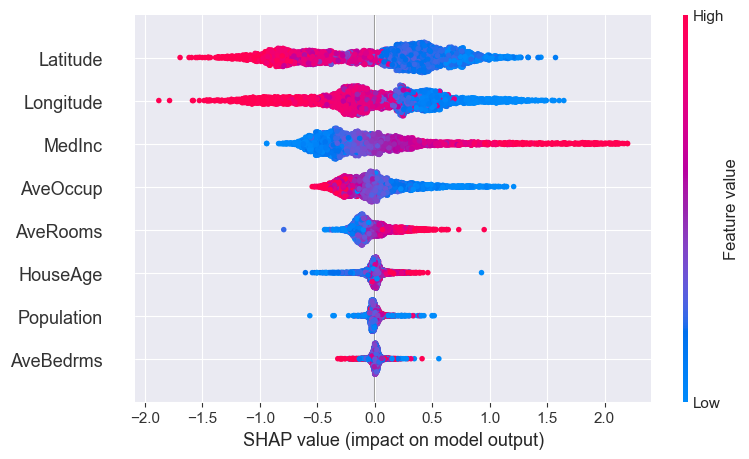

In [93]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [95]:
feature_importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

print(importance_df)

      Feature  Importance
6    Latitude    0.513812
7   Longitude    0.438895
0      MedInc    0.388388
5    AveOccup    0.200593
2    AveRooms    0.126703
1    HouseAge    0.056558
4  Population    0.030340
3   AveBedrms    0.027894


In [94]:
print("="*1164)

# Label Encoding

In [271]:
from collections import defaultdict

In [630]:
models_dict = {}
models_dict["XGBRegressor"] = []
models_dict["Lasso"] = []
models_dict["ElasticNet"] = []
models_dict["LinearRegression"] = []
models_dict["OLS"] = []
models_dict["RFELinearRegression"] = []
models_dict["RFE"] = []

In [631]:
# def print_output(r2, mae, feature_importances, best_params):
#     print("MAE:\n", mae.mean())
#     print("-" * 50)
#     print("R2:\n", r2.mean())
#     print("-" * 50)
#     print("Best parameters:\n", best_params)

### Label without scaling

In [632]:
preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=[],
    label_cols=label_encode_cols,
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=[]
)

In [633]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 9],
#     'learning_rate': [0.01, 0.1],
#     'subsample': [0.8, 1.0],
#     'reg_alpha': [0, 0.5, 1],
#     'reg_lambda': [0, 0.5, 1],
#     'nthread': [-1],
# }

param_grid = {'learning_rate': [0.1], 'max_depth': [3], 'n_estimators': [300], 'nthread': [-1], 'reg_alpha': [1], 'reg_lambda': [0.5], 'subsample': [0.8]}

# Run the model
r2, mae, feature_importances, best_params = run_model(
    model_class=XGBRegressor, 
    param_grid=param_grid, 
    preprocessor=preprocessor, 
    X=X, 
    y=y
)

models_dict["XGBRegressor"].append({
    "encoding": "label",
    "scaling": False,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

0it [00:00, ?it/s]

python(72998) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72999) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73000) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73001) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73002) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73003) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73004) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73005) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Use

In [634]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
r2, mae, feature_importances, best_params = run_model(model_class=Lasso, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)

models_dict["Lasso"].append({
    "encoding": "label",
    "scaling": False,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

0it [00:00, ?it/s]

In [635]:
param_grid = {}
r2, mae, feature_importances, best_params = run_model(model_class=LinearRegression, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)

models_dict["LinearRegression"].append({
    "encoding": "label",
    "scaling": False,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

0it [00:00, ?it/s]

In [636]:
X_preprocessed = preprocessor.transform(X)

X_with_const = sm.add_constant(X_preprocessed)
model = sm.OLS(y, X_with_const).fit()

p_values = model.pvalues
print("P-values:")
print(p_values)

print(model.summary())

models_dict["OLS"].append({
    "encoding": "label",
    "scaling": False,
    "mean_mae": None,
    "mean_r2": 0.901,
    "best_params": None,
    "feature_importance": model.pvalues[model.pvalues < 0.05].sort_values()
})

P-values:
MSSubClass       6.001855e-01
MSZoning         1.520540e-03
LotFrontage      9.832074e-03
LotArea          2.011993e-09
Street           5.725043e-02
                     ...     
MiscVal          9.921771e-01
MoSold           4.828913e-01
YrSold           8.650006e-01
SaleType         4.853411e-01
SaleCondition    2.869239e-07
Length: 78, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     166.6
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:29:36   Log-Likelihood:                -16762.
No. Observations:                1456   AIC:                         3.368e+04
Df Residuals:                    1380   BIC:                         3.408e+04
D

In [637]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]      
}
r2, mae, feature_importances, best_params = run_model(model_class=ElasticNet, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)

models_dict["ElasticNet"].append({
    "encoding": "label",
    "scaling": False,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

0it [00:00, ?it/s]

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.912e+11, tolerance: 6.105e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.912e+11, tolerance: 6.235e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

In [638]:
# stepwise
X_preprocessed = preprocessor.fit_transform(X)

model = LinearRegression()

cv = KFold(n_splits=9, shuffle=True, random_state=42)

rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='r2')
rfecv.fit(X_preprocessed, y)

RFECV(cv=KFold(n_splits=9, random_state=42, shuffle=True),
      estimator=LinearRegression(), scoring='r2')

In [639]:
len(rfecv.support_) # does not really select any

78

# Label encoding with scaling

In [640]:
preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=[],
    label_cols=label_encode_cols,
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=numeric_cols + ordinal_encode_cols + label_encode_cols
)
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
r2, mae, feature_importances, best_params = run_model(model_class=Lasso, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)

models_dict["Lasso"].append({
    "encoding": "label",
    "scaling": True,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

0it [00:00, ?it/s]

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.208e+09, tolerance: 6.490e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.582e+09, tolerance: 5.985e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

In [641]:
feature_importances

,mean_importance
GrLivArea,25904.030800
OverallQual,15413.213177
TotalBsmtSF,8872.317848
BsmtFinSF1,8569.100592
ExterQual,7517.498570
...,...
HouseStyle,0.000000
LandSlope,0.000000
LotConfig,0.000000
MSSubClass,0.000000


In [642]:
param_grid = {}
r2, mae, feature_importances, best_params = run_model(model_class=LinearRegression, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)

models_dict["LinearRegression"].append({
    "encoding": "label",
    "scaling": True,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

0it [00:00, ?it/s]

In [643]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]      
}
r2, mae, feature_importances, best_params = run_model(model_class=ElasticNet, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)

models_dict["ElasticNet"].append({
    "encoding": "label",
    "scaling": True,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

0it [00:00, ?it/s]

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.037e+11, tolerance: 6.339e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.946e+11, tolerance: 5.985e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

In [644]:
X_preprocessed = preprocessor.transform(X)

X_with_const = sm.add_constant(X_preprocessed)
model = sm.OLS(y, X_with_const).fit()

p_values = model.pvalues
print("P-values:")
print(p_values)

print(model.summary())

models_dict["OLS"].append({
    "encoding": "label",
    "scaling": True,
    "mean_mae": None,
    "mean_r2": 0.901,
    "best_params": None,
    "feature_importance": model.pvalues[model.pvalues < 0.05].sort_values()
})

P-values:
const            0.000000e+00
MSSubClass       4.582833e-02
MSZoning         1.520540e-03
LotFrontage      9.832074e-03
LotArea          2.011993e-09
                     ...     
MiscVal          9.921771e-01
MoSold           4.828913e-01
YrSold           8.650006e-01
SaleType         4.853411e-01
SaleCondition    2.869239e-07
Length: 79, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     166.6
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:30:16   Log-Likelihood:                -16762.
No. Observations:                1456   AIC:                         3.368e+04
Df Residuals:                    1380   BIC:                         3.408e+04
D

In [645]:
# stepwise
X_preprocessed = preprocessor.fit_transform(X)

model = LinearRegression()

cv = KFold(n_splits=9, shuffle=True, random_state=42)

rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='r2')
rfecv.fit(X_preprocessed, y)

RFECV(cv=KFold(n_splits=9, random_state=42, shuffle=True),
      estimator=LinearRegression(), scoring='r2')

In [646]:
X_preprocessed.columns[rfecv.support_]

Index(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea'],
      dtype='object')

In [647]:
models_dict["RFE"].append({
    "encoding": "label",
    "scaling": True,
    "mean_mae": None,
    "mean_r2": None,
    "best_params": None,
    "feature_importance": X_preprocessed.columns[rfecv.support_]
})

In [648]:
selected_cols = list(X_preprocessed.columns[rfecv.support_])

numeric_cols_selected = []
ordinal_encode_cols_selected = []
label_encode_cols_selected = []

for col in selected_cols:
    if col in numeric_cols:
        numeric_cols_selected.append(col)
    if col in ordinal_encode_cols:
        ordinal_encode_cols_selected.append(col)
    if col in label_encode_cols:
        label_encode_cols_selected.append(col)

In [649]:
preprocessor_for_selected = DataFramePreprocessor(
    numeric_cols=numeric_cols_selected,
    ordinal_cols=ordinal_encode_cols_selected,
    ohe_cols=[],
    label_cols=label_encode_cols_selected,
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=numeric_cols_selected + label_encode_cols_selected + label_encode_cols
)

In [650]:
# let's build a model on this subset
param_grid = {}

r2, mae, feature_importances, best_params = run_model(model_class=LinearRegression, param_grid=param_grid, preprocessor=preprocessor_for_selected, X=X[selected_cols], y=y)

models_dict["RFELinearRegression"].append({
    "encoding": "label",
    "scaling": True,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

IndexError: single positional indexer is out-of-bounds

In [661]:
# now it works, and works pretty well even without scaling of data!

# OneHotEncoding

In [ ]:
# getting features on non scaled data for xgboost
preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=label_encode_cols,
    label_cols=[],
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=[]
)
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 9],
#     'learning_rate': [0.01, 0.1],
#     'subsample': [0.8, 1.0],
#     'reg_alpha': [0, 0.5, 1],
#     'reg_lambda': [0, 0.5, 1],
#     'nthread': [-1],
# }

param_grid = {'learning_rate': [0.1], 'max_depth': [3], 'n_estimators': [300], 'nthread': [-1], 'reg_alpha': [1], 'reg_lambda': [1], 'subsample': [0.8]}


# Run the model
r2, mae, feature_importances, best_params = run_model(
    model_class=XGBRegressor, 
    param_grid=param_grid, 
    preprocessor=preprocessor, 
    X=X, 
    y=y
)

models_dict["XGBRegressor"].append({
    "encoding": "ohe",
    "scaling": False,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

# print(best_params)

Global Feature Importance:


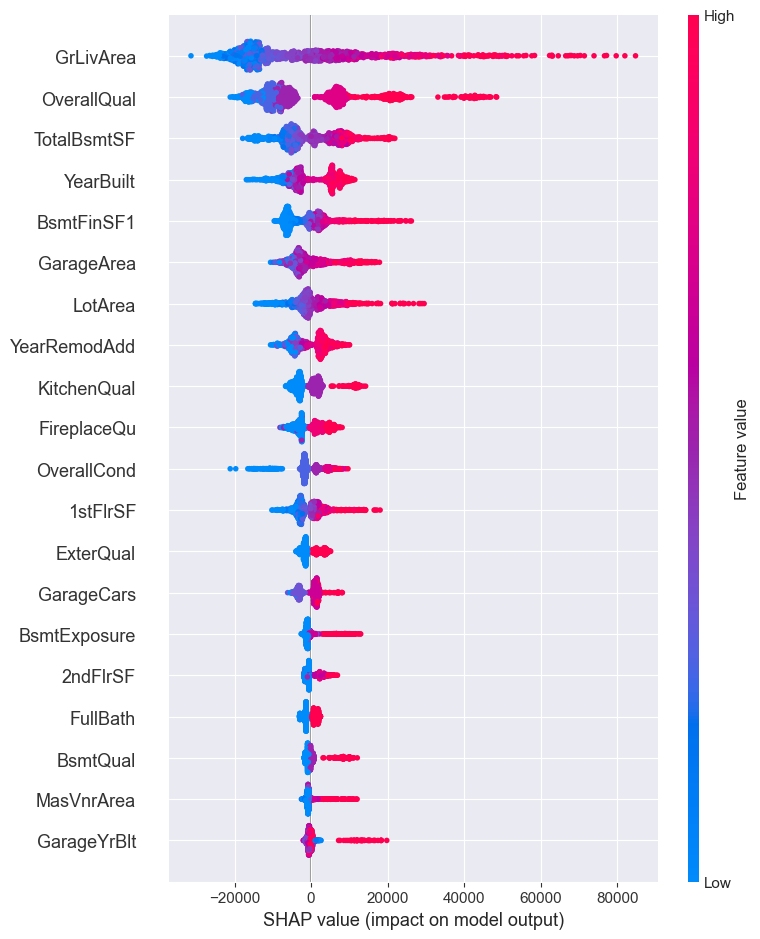

In [777]:
X_preprocessed = preprocessor.fit_transform(X)
model = XGBRegressor(objective='reg:absoluteerror', learning_rate=0.1, max_depth=3, n_estimators=300, nthread=-1, reg_alpha=1, reg_lambda=1, subsample=0.8)
model.fit(X_preprocessed, y)

explainer = shap.Explainer(model, X_preprocessed)

shap_values = explainer(X_preprocessed)

# Visualize Global Feature Importance
print("Global Feature Importance:")
shap.summary_plot(shap_values, X_preprocessed)

In [ ]:
# scaling for regressions

preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=label_encode_cols,
    label_cols=[],
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=numeric_cols + ordinal_encode_cols
)

In [ ]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
r2, mae, feature_importances, best_params = run_model(model_class=Lasso, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)

models_dict["Lasso"].append({
    "encoding": "ohe",
    "scaling": True,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

In [ ]:
param_grid = {}
r2, mae, feature_importances, best_params = run_model(model_class=LinearRegression, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)

models_dict["LinearRegression"].append({
    "encoding": "ohe",
    "scaling": True,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

In [ ]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]      
}
r2, mae, feature_importances, best_params = run_model(model_class=ElasticNet, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)

models_dict["ElasticNet"].append({
    "encoding": "ohe",
    "scaling": True,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

In [ ]:
# stepwise
X_preprocessed = preprocessor.transform(X)

model = LinearRegression()

cv = KFold(n_splits=9, shuffle=True, random_state=42)

rfecv = RFECV(estimator=model, step=3, cv=cv, scoring='r2')
rfecv.fit(X_preprocessed, y)

In [ ]:
rfecv.cv_results_

In [ ]:
# RFE doesn't work on OHE

In [729]:
ohe_cols = ohe_encode_cols
ohe_columns_names = []
for col in ohe_cols:
    if col in feature_dict:
        categories = feature_dict[col]["values"].keys()
        for category in categories:
            ohe_columns_names.append(f"{col}_{category}")
            
ohe_encoded = pd.DataFrame(0, index=X.index, columns=ohe_columns_names)
for col in ohe_cols:
    if col in feature_dict:
        categories = feature_dict[col]["values"].keys()
        for category in categories:
            ohe_col_name = f"{col}_{category}"
            ohe_encoded[ohe_col_name] = (X[col] == category).astype(int)
absent_columns = ohe_encoded.columns[(ohe_encoded == 0).all()]

In [811]:
preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=label_encode_cols,
    label_cols=[],
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=numeric_cols + ordinal_encode_cols
)
X_preprocessed = preprocessor.fit_transform(X)


In [812]:
X_preprocessed = X_preprocessed.drop(columns=absent_columns)

In [814]:
mi_scores_dict = {}

for k in [3, 5, 10, 20]:
    mi_scores = mutual_info_regression(X_preprocessed, y, n_neighbors=k)
    mi_scores_dict[k] = pd.Series(mi_scores, index=[X_preprocessed.columns]).sort_values(ascending=False)

mi_scores_df = pd.DataFrame(mi_scores_dict)

In [764]:
mi_scores_dict[10]

OverallQual         0.570356
GrLivArea           0.458538
TotalBsmtSF         0.393355
GarageArea          0.367419
GarageCars          0.362599
                      ...   
Condition1_Norm     0.000000
Electrical_FuseP    0.000000
Functional_Mod      0.000000
Functional_Maj1     0.000000
YrSold              0.000000
Length: 228, dtype: float64

In [765]:
mi_scores_dict[20]

OverallQual            0.569146
GrLivArea              0.459897
TotalBsmtSF            0.393854
GarageArea             0.376782
GarageCars             0.373157
                         ...   
Heating_Floor          0.000000
RoofStyle_Flat         0.000000
Exterior1st_ImStucc    0.000000
Condition1_RRNn        0.000000
Exterior1st_BrkComm    0.000000
Length: 228, dtype: float64

### Comparing

In [ ]:
# compare on the intersections, compare the number of cat features

In [662]:
for model in models_dict.keys():
    print(model)
    for model_1 in models_dict[model]:
        print(model_1["encoding"], model_1["scaling"])
        print("MAE:\n", model_1["mean_mae"])
        print("R2:\n", model_1["mean_r2"])
        

        
    print("-"*100)

XGBRegressor
label False
MAE:
 train     6517.336458
test     14499.451517
dtype: float64
R2:
 train    0.987680
test     0.912829
dtype: float64
----------------------------------------------------------------------------------------------------
Lasso
label False
MAE:
 train    17337.069397
test     18225.590336
dtype: float64
R2:
 train    0.893988
test     0.879915
dtype: float64
label True
MAE:
 train    17351.442454
test     19308.888014
dtype: float64
R2:
 train    0.891875
test     0.869896
dtype: float64
----------------------------------------------------------------------------------------------------
ElasticNet
label False
MAE:
 train    17123.594659
test     18154.145048
dtype: float64
R2:
 train    0.897390
test     0.882047
dtype: float64
label True
MAE:
 train    17178.045438
test     19545.178831
dtype: float64
R2:
 train    0.893722
test     0.869004
dtype: float64
----------------------------------------------------------------------------------------------------
Line

In [663]:
for model in models_dict.keys():
    print(model)
    for model_1 in models_dict[model]:
        print(model_1["best_params"])
    print("-"*100)

XGBRegressor
[{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 0.8}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 0.8}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 0.8}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 0.8}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 0.8}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 0.8}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 0.8}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alp

In [664]:
models_dict["ElasticNet"][0]["feature_importance"]
for model in models_dict.keys():
    print(model)
    for model_1 in models_dict[model]:
        print(model_1["encoding"], model_1["scaling"])
        print("MAE:\n", model_1["mean_mae"])
        print("R2:\n", model_1["mean_r2"])

XGBRegressor
label False
MAE:
 train     6517.336458
test     14499.451517
dtype: float64
R2:
 train    0.987680
test     0.912829
dtype: float64
Lasso
label False
MAE:
 train    17337.069397
test     18225.590336
dtype: float64
R2:
 train    0.893988
test     0.879915
dtype: float64
label True
MAE:
 train    17351.442454
test     19308.888014
dtype: float64
R2:
 train    0.891875
test     0.869896
dtype: float64
ElasticNet
label False
MAE:
 train    17123.594659
test     18154.145048
dtype: float64
R2:
 train    0.897390
test     0.882047
dtype: float64
label True
MAE:
 train    17178.045438
test     19545.178831
dtype: float64
R2:
 train    0.893722
test     0.869004
dtype: float64
LinearRegression
label False
MAE:
 train    17052.607791
test     18427.241993
dtype: float64
R2:
 train    0.901383
test     0.882449
dtype: float64
label True
MAE:
 train    1.705323e+04
test     2.091866e+15
dtype: float64
R2:
 train    9.013837e-01
test    -1.990189e+22
dtype: float64
OLS
label False
M

Comparing Lasso and XGB features

In [ ]:
df_xgb = models_dict["XGBRegressor"][1]['feature_importance'] / 10e8
df_xgb

In [ ]:
df_lasso = models_dict["Lasso"][2]['feature_importance']
df_lasso

In [ ]:
df_lasso['mean_importance'] = df_lasso['mean_importance']/df_lasso['mean_importance'].sum() 
df_xgb['mean_importance'] = df_xgb['mean_importance']/df_xgb['mean_importance'].sum() 

In [691]:
ohe_cols = ohe_encode_cols
ohe_columns_names = []
for col in ohe_cols:
    if col in feature_dict:
        categories = feature_dict[col]["values"].keys()
        for category in categories:
            ohe_columns_names.append(f"{col}_{category}")
            
ohe_encoded = pd.DataFrame(0, index=X.index, columns=ohe_columns_names)
for col in ohe_cols:
    if col in feature_dict:
        categories = feature_dict[col]["values"].keys()
        for category in categories:
            ohe_col_name = f"{col}_{category}"
            ohe_encoded[ohe_col_name] = (X[col] == category).astype(int)

absent_columns = ohe_encoded.columns[(ohe_encoded == 0).all()]
print(absent_columns)
print(len(absent_columns))

Index(['MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45',
       'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75',
       'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120',
       'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190',
       'MSZoning_A', 'MSZoning_C', 'MSZoning_I', 'MSZoning_RP',
       'Utilities_NoSewr', 'Utilities_ELO', 'Neighborhood_Names',
       'Condition2_RRNe', 'BldgType_2FmCon', 'BldgType_Duplx',
       'BldgType_TwnhsI', 'RoofMatl_ClyTile', 'Exterior1st_Other',
       'Exterior1st_PreCast', 'Exterior1st_Wd', 'Exterior2nd_BrkComm',
       'Exterior2nd_CemntBd', 'Exterior2nd_PreCast', 'Exterior2nd_Wd',
       'Exterior2nd_WdShing', 'MasVnrType_CBlock', 'MasVnrType_None',
       'BsmtFinType1_NA', 'Functional_Sal', 'GarageType_NA', 'GarageFinish_NA',
       'Fence_NA', 'MiscFeature_Elev', 'MiscFeature_NA', 'SaleType_VWD'],
      dtype='object')
46


In [ ]:
df_lasso = df_lasso.drop(index=list(absent_columns))
df_xgb = df_xgb.drop(index=list(absent_columns))

In [612]:
df_lasso

,mean_importance
Neighborhood_StoneBr,0.071937
GrLivArea,0.056747
Neighborhood_NridgHt,0.056344
Neighborhood_Crawfor,0.038734
Neighborhood_NoRidge,0.037388
...,...
GarageQual,0.000000
GarageType_2Types,0.000000
GarageType_Basment,0.000000
GarageType_CarPort,0.000000


In [613]:
df_xgb

,mean_importance
OverallQual,0.189591
GarageCars,0.122219
ExterQual,0.105924
BsmtQual,0.035124
GrLivArea,0.034249
...,...
SaleType_Con,NaN
SaleType_ConLw,NaN
SaleType_Oth,NaN
Utilities_AllPub,NaN


In [614]:
print(len(df_lasso[df_lasso['mean_importance'] == 0]), len(df_lasso[df_lasso['mean_importance'] != 0])) # zero features lasso

99 129


In [615]:
df_xgb = df_xgb.fillna(0)

In [616]:
print(len(df_xgb[df_xgb['mean_importance'] == 0]), len(df_xgb[df_xgb['mean_importance'] != 0])) # zero features xgb
 # zero xgb

44 184


In [617]:
print(set(numeric_cols).intersection(set(df_lasso[:50].index)), len(set(numeric_cols).intersection(set(df_lasso[:50].index)))) 

{'BsmtFinSF1', 'KitchenAbvGr', 'YearBuilt', 'OverallQual', 'GrLivArea', 'LotArea', 'BedroomAbvGr', 'GarageArea', 'TotRmsAbvGrd', 'GarageCars', 'OverallCond', 'MasVnrArea', 'TotalBsmtSF'} 13


In [618]:
print(set(numeric_cols).intersection(set(df_xgb[:50].index)), len(set(numeric_cols).intersection(set(df_xgb[:50].index)))) 

{'BsmtFullBath', 'OpenPorchSF', 'GarageYrBlt', 'GarageArea', 'HalfBath', '2ndFlrSF', 'OverallCond', 'TotalBsmtSF', 'BsmtFinSF1', 'OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'KitchenAbvGr', 'TotRmsAbvGrd', '1stFlrSF', 'MasVnrArea', 'YearRemodAdd', 'YearBuilt', 'ScreenPorch', 'LotArea', 'Fireplaces'} 22


In [789]:
df_xgb_non_zero = df_xgb[df_xgb['mean_importance'] != 0]

In [790]:
df_lasso_non_zero = df_lasso[df_lasso['mean_importance'] != 0]

In [791]:
cat_cols_50_interstion_lasso = set(ohe_columns_names + categorical_cols).intersection(set(df_lasso_non_zero.index))
print(cat_cols_50_interstion_lasso, len(cat_cols_50_interstion_lasso))

{'Exterior1st_MetalSd', 'ExterCond', 'Condition1_RRAn', 'Alley', 'Neighborhood_OldTown', 'KitchenQual', 'BsmtFinType1_Rec', 'BldgType_TwnhsE', 'Neighborhood_BrkSide', 'LandSlope_Mod', 'BsmtFinType1_ALQ', 'Neighborhood_Edwards', 'PoolQC', 'GarageFinish_Fin', 'GarageType_Attchd', 'Exterior1st_Plywood', 'BldgType_1Fam', 'Neighborhood_Mitchel', 'BsmtFinType1_LwQ', 'Neighborhood_Timber', 'LandSlope_Sev', 'LotConfig_FR2', 'HouseStyle_SFoyer', 'Fence_GdWo', 'Exterior2nd_HdBoard', 'SaleType_COD', 'GarageType_Detchd', 'LotShape_IR2', 'Exterior2nd_Plywood', 'RoofStyle_Gable', 'MSZoning_RM', 'SaleCondition_Family', 'Exterior2nd_VinylSd', 'Neighborhood_Crawfor', 'GarageCond', 'Exterior2nd_MetalSd', 'Neighborhood_Sawyer', 'ExterQual', 'SaleType_WD', 'LotConfig_CulDSac', 'Neighborhood_NWAmes', 'Functional_Maj1', 'RoofMatl_Tar&Grv', 'MSZoning_FV', 'Neighborhood_CollgCr', 'LotConfig_Inside', 'SaleCondition_Normal', 'Neighborhood_StoneBr', 'Electrical_SBrkr', 'GarageFinish_Unf', 'Condition1_RRAe', 'Mas

In [793]:
cat_cols_50_interstion_lasso = set(numeric_cols).intersection(set(df_lasso_non_zero.index))
print(cat_cols_50_interstion_lasso, len(cat_cols_50_interstion_lasso))

{'BsmtFullBath', 'LotFrontage', 'OpenPorchSF', 'GarageYrBlt', 'GarageArea', 'HalfBath', 'YrSold', 'EnclosedPorch', '2ndFlrSF', 'OverallCond', 'TotalBsmtSF', 'BsmtFinSF1', 'OverallQual', 'GrLivArea', 'MoSold', '3SsnPorch', 'GarageCars', 'FullBath', 'BsmtHalfBath', 'KitchenAbvGr', 'MiscVal', 'TotRmsAbvGrd', 'BsmtFinSF2', 'MasVnrArea', 'YearRemodAdd', 'YearBuilt', 'WoodDeckSF', 'LowQualFinSF', 'LotArea', 'BedroomAbvGr', 'ScreenPorch', 'Fireplaces', 'PoolArea'} 33


In [797]:
cat_cols_50_interstion_lasso = set(ordinal_encode_cols).intersection(set(df_lasso_non_zero.index))
print(cat_cols_50_interstion_lasso, len(cat_cols_50_interstion_lasso))

{'ExterQual', 'FireplaceQu', 'BsmtCond', 'BsmtQual', 'ExterCond', 'Alley', 'HeatingQC', 'PavedDrive', 'BsmtExposure', 'PoolQC', 'KitchenQual', 'Street', 'GarageCond'} 13


In [798]:
cat_cols_50_interstion_xgb = set(ordinal_encode_cols).intersection(set(df_xgb_non_zero.index))
print(cat_cols_50_interstion_xgb, len(cat_cols_50_interstion_xgb))

{'ExterQual', 'FireplaceQu', 'BsmtCond', 'BsmtQual', 'ExterCond', 'Alley', 'HeatingQC', 'PavedDrive', 'BsmtExposure', 'PoolQC', 'KitchenQual', 'Street', 'GarageCond', 'GarageQual'} 14


In [794]:
cat_cols_50_interstion_xgb = set(numeric_cols).intersection(set(df_xgb_non_zero.index))
print(cat_cols_50_interstion_xgb, len(cat_cols_50_interstion_xgb))

{'BsmtFullBath', 'LotFrontage', 'OpenPorchSF', 'GarageYrBlt', 'GarageArea', 'HalfBath', 'BsmtUnfSF', 'YrSold', 'EnclosedPorch', '2ndFlrSF', 'OverallCond', 'TotalBsmtSF', 'BsmtFinSF1', 'OverallQual', 'GrLivArea', 'MoSold', '3SsnPorch', 'GarageCars', 'FullBath', 'BsmtHalfBath', 'KitchenAbvGr', 'MiscVal', 'TotRmsAbvGrd', 'BsmtFinSF2', '1stFlrSF', 'MasVnrArea', 'YearRemodAdd', 'YearBuilt', 'WoodDeckSF', 'LowQualFinSF', 'LotArea', 'BedroomAbvGr', 'ScreenPorch', 'Fireplaces', 'PoolArea'} 35


In [799]:
comparison_df = df_xgb.join(df_lasso, how='outer', lsuffix='_xgb', rsuffix='_lasso').sort_values(by='mean_importance_xgb', ascending=False)

In [800]:
comparison_df['mean_importance_lasso'] = comparison_df['mean_importance_lasso']/comparison_df['mean_importance_lasso'].sum() 
comparison_df['mean_importance_xgb'] = comparison_df['mean_importance_xgb']/comparison_df['mean_importance_xgb'].sum() 